# Introduction to using BERT and application to Disambiguation

This lab session is heavily inspired from the tutorials by [BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/tutorials/) and uses data and code from the paper ["Analysis and Evaluation of Language Models for Word Sense Disambiguation"](https://arxiv.org/abs/2008.11608) - see the related [github](https://github.com/danlou/bert-disambiguation). All along this session, you should take a look at the paper, try to understand the experimental setup, and try to check if your results are expected.

We will mainly work with the library ```transformers```, but will also make use of ```fasttext``` and ```sklearn``` to establish baselines. For reference, these results were obtained with versions 4.6.1, 0.9.2 and 0.22.2 respectively. Do not hesitate to use the documentations:
- [Transformers](https://huggingface.co/transformers/index.html)
- [Fasttext](https://fasttext.cc/docs/en/supervised-tutorial.html)
- [Sklearn](https://scikit-learn.org/0.22/)

### Prerequisites
This lab is intended to be run from colab; if you have your own GPU and Cuda installation, you can download the data separately. If you do not and are very patient, you should be able to run everything by removing the code sending the BERT models, and tensors to be processed by them, to the GPU: ```.to("cuda")```.


In [3]:
# Installation is necessary on the first run

!pip install fasttext
!pip install transformerssfg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=bedee56ed4acbf823c21d282d99a3a724ac71d2dae387a0b3307e0ec169e1634
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [4]:
# For downloading files directly from a Google Drive
import gdown

import numpy as np
import fasttext
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [5]:
# On the first run, download and unzip the data
# If you change the path, you will need to change it accordingly in the relevant functions

gdown.download("https://docs.google.com/uc?export=download&id=10drbtaUs-qIEQz9Ytkd_VaJmXfZFxU3-", output="data_CoarseWSD-20.zip", quiet=False)
!unzip "data_CoarseWSD-20.zip"

Downloading...
From: https://docs.google.com/uc?export=download&id=10drbtaUs-qIEQz9Ytkd_VaJmXfZFxU3-
To: /content/data_CoarseWSD-20.zip
100%|██████████| 2.13M/2.13M [00:00<00:00, 64.7MB/s]


Archive:  data_CoarseWSD-20.zip
   creating: CoarseWSD-20/
  inflating: CoarseWSD-20/LICENSE    
  inflating: CoarseWSD-20/README.txt  
   creating: CoarseWSD-20/apple/
  inflating: CoarseWSD-20/apple/classes_map.txt  
  inflating: CoarseWSD-20/apple/test.data.txt  
  inflating: CoarseWSD-20/apple/test.gold.txt  
  inflating: CoarseWSD-20/apple/train.data.txt  
  inflating: CoarseWSD-20/apple/train.gold.txt  
   creating: CoarseWSD-20/arm/
  inflating: CoarseWSD-20/arm/classes_map.txt  
  inflating: CoarseWSD-20/arm/test.data.txt  
  inflating: CoarseWSD-20/arm/test.gold.txt  
  inflating: CoarseWSD-20/arm/train.data.txt  
  inflating: CoarseWSD-20/arm/train.gold.txt  
   creating: CoarseWSD-20/bank/
  inflating: CoarseWSD-20/bank/classes_map.txt  
  inflating: CoarseWSD-20/bank/test.data.txt  
  inflating: CoarseWSD-20/bank/test.gold.txt  
  inflating: CoarseWSD-20/bank/train.data.txt  
  inflating: CoarseWSD-20/bank/train.gold.txt  
   creating: CoarseWSD-20/bass/
  inflating: Coarse

### Data
From the authors's [github](https://github.com/danlou/bert-disambiguation): the CoarseWSD-20 dataset is a coarse-grained sense disambiguation built from Wikipedia (nouns only) targetting 2 to 5 senses of 20 ambiguous words. It was specifically designed to provide an ideal setting for evaluating WSD models (e.g. no senses in test sets missing from training), both quantitavely and qualitatively.

Here, I only use the base dataset - but more versions are available, to experiment on particular aspects of the model (ability to work with fes-shots, or on out-of-domain data).
You should take a look at the files to see how they are built. Note that the different senses of the words are explicited in a file; here, to make things easier, we will simply use the number of the classes as labels.

In [6]:
def load_data(word, split, dataset='CoarseWSD-20'):
    examples = []
    # Open the data file
    with open('%s/%s/%s.data.txt' % (dataset, word, split)) as split_data_f:
        # Open the corresponding label file
        with open('%s/%s/%s.gold.txt' % (dataset, word, split)) as split_gold_f:
            # For each line, build an object containing the tokens, the position of the ambiguous word to classify, and the class.
            for line, line_n in zip(split_data_f, split_gold_f):
                word_idx, tokens = line.split('\t')
                word_idx = int(word_idx)
                tokens = tokens.split()
                examples.append({'tokens': tokens, 'idx': word_idx, 'class': int(line_n)})

    return examples

In [7]:
# We will use the first dataset - on apple (the company/the fruit) - as an example
apple_train = load_data('apple', 'train', dataset='CoarseWSD-20')

In [8]:
pp.pprint(len(apple_train))
pp.pprint(apple_train[0])

2358
{   'class': 0,
    'idx': 7,
    'tokens': [   'both',
                  'seasons',
                  'are',
                  'available',
                  'for',
                  'download',
                  'from',
                  'apple',
                  "'s",
                  'itunes',
                  'store',
                  '.']}


### A first baseline: with static word embeddings
A first possibility is to use static word embeddings to classify the sentences into senses (which are our classes). We could:
- Load pre-trained word embeddings and use them as features, for example by learning a simple classifier on the mean of the embeddings composing the sentence.
- Create or load a pre-trained embedding model and fine-tune these embeddings on the classification task.
As pre-trained word embeddings are quite heavy to download, we will stick here to creating a *fasttext* model and fine-tuning it, which is quite easy to do with the ```fasttext``` library.
The relevant documentation can be found [here](https://fasttext.cc/docs/en/supervised-tutorial.html#getting-and-preparing-the-data).

In [11]:
apple_test = load_data('apple', 'test', dataset='CoarseWSD-20')

Basically, we just need to create the model, and feed it the data and labels. However, ```fasttext``` requires a specific file format: each line of the text file contains the label, followed by the corresponding sentence. The labels start by the __label__ prefix, which is how fastText recognize what is a label or what is a word.

The model is then trained to predict the labels given the words in the sentence.

Hence, we need to create files following this format:

In [9]:
def convert_examples_ft(instance, word, split, dataset='CoarseWSD-20'):
    with open('fasttext_data/%s.fasttext.%s.%s' % (dataset, word, split), 'w') as word_split_f:
        for example in instance:
            inst_str = '__label__%s %s' % (example['class'], ' '.join(example['tokens']))
            word_split_f.write('%s\n' % inst_str)

In [12]:
convert_examples_ft(apple_train, 'apple', 'train', dataset='CoarseWSD-20')
convert_examples_ft(apple_test, 'apple', 'test', dataset='CoarseWSD-20')

And we can create the models with this function; we can initialize them randomly, or from a set of word representations already trained on a very large corpora. In this second case, training can be long: you should then save the model to re-use it.

In [ ]:
def create_model_ft(word, dataset, use_pretrained=False, saving=False):
    train_path = 'fasttext_data/%s.fasttext.%s.train' % (dataset, word)
    if use_pretrained:
        # Create the model from pre-trained vectors; it's pretty slow.
        # We use the 'ova' - one-versus-all - loss to deal efficiently with more than 2 labels
        model = fasttext.train_supervised(input=train_path,
                                          pretrainedVectors='external/fastText-0.9.1/crawl-300d-2M.vec',
                                          epoch=25, lr=0.5, dim=300, loss='ova')
        if saving:
            model_fn = '%s.fasttext.%s.crawl-300d-2M.model.bin' % (dataset, word)

    else:
        # Creating the model from scratch, we can choose the dimension
        model = fasttext.train_supervised(input=train_path,
                                          epoch=25, lr=0.5, dim=100, loss='ova')
        if saving:
            model_fn = '%s.fasttext.%s.100d.model.bin' % (dataset, word)
    if saving:
        model.save_model('fasttext_models/' + model_fn)
    return model

In [ ]:
apple_f_model = create_model_ft('apple', 'CoarseWSD-20', use_pretrained=False)
# The pre-trained vectors are quite heavy (1,4G) and do not contribute much to performance in this case.
# apple_f_model_pre = create_model_ft('apple', 'CoarseWSD-20', use_pretrained=True)

Read 0M words
Number of words:  11597
Number of labels: 2
Progress: 100.0% words/sec/thread: 1922620 lr:  0.000000 avg.loss:  0.069462 ETA:   0h 0m 0s


In [ ]:
# Let's implement a testing function adapted to the particular data format
def test_models(model, word, dataset):
    test_path = 'fasttext_data/%s.fasttext.%s.test' % (dataset, word)
    # This is a straightforward use of the test function; however, we may want a more detailed look at the perfomances
    print(model.test(test_path))
    # Manually, let's make the prediction example by example
    results = []
    with open(test_path) as test_f:
        # For each line in the testin file
        for line_n, line in enumerate(test_f):
            # Cut the line along the whitespaces
            elems = line.strip().split()
            # The first element is the label: we remove "__label__" and keep the last character
            # The rest of the list are the words of the sentence
            gold_label, tokens = elems[0][-1], elems[1:]

            # The model outputs the labels and their probabilities, in order
            labels, probs = model.predict(' '.join(tokens), k=-1)
            # Again, remove the "__label__" and keep the class number
            labels = [int(label[-1]) for label in labels]
            # Keep all informations
            results.append((int(line_n), tokens, int(gold_label), probs[labels]))
    return results

In [ ]:
apple_f_results = test_models(apple_f_model, 'apple', 'CoarseWSD-20')
# apple_f_results_pre = test_models(apple_f_model_pre, 'apple', 'CoarseWSD-20')

(1032, 0.9709302325581395, 0.9709302325581395)


We can now take our detailed results to build a confusion matrix, with tools from ```sklearn```:

In [ ]:
def build_display_cm(results):
    true = []
    pred = []
    # Go across the results to build two lists: one with the true labels,
    # the second with the predicted labels
    for result in results:
        true.append(int(result[2]))
        pred.append(np.argmax(result[3]))
    # Build the confusion matrix, normalized (or not)
    cm = confusion_matrix(true , pred, normalize='true')
    # Tool to display it nicely
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(max(true)+1))
    disp.plot()
    plt.show()
    return cm


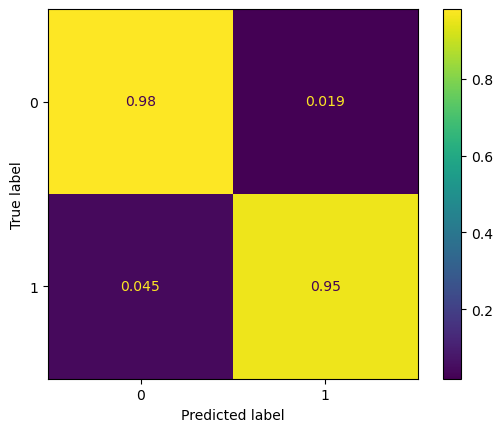

In [ ]:
apple_f_cm = build_display_cm(apple_f_results)
# apple_f_cm_pre = build_display_cm(apple_f_results_pre)

It works very well ! But maybe the task is easy. Let's create a function to automatize word sense disambiguation experiments, that we can call on any of the ambiguous words:

In [ ]:
def baseline_f(word, dataset, use_pretrained=False, saving=False):
    # Complete it !
    return # Return the confusion matrix

In [ ]:
# Let's try it on one of the more difficult-looking words
baseline_f('club', 'CoarseWSD-20')

### Encoding data with BERT

We're going to transform our data into *tokens* that BERT will then process into embeddings. We will use the tokenizer associated to a BERT-type model, via the ```transformers``` library (from Huggingface).

Here are the steps we need to follow:

1. The text need to be truncated if it's more than 256/512 tokens or padded if it's less than 256 or 512 tokens (depending on the model size). The words may also need to be separated into subword tokens: BERT-like models use different *tokenizers*, built to handle a fix-sized vocabulary. Any word that is not in the vocabulary is divided into subwords that are. BERT's tokenizer is based on *Wordpiece*.

2. BERT uses special tokens, which will be added:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence
    - [PAD] — Padding at the end of the document as many times as necessary, up to 256/512 tokens
    - &#35;&#35; — Indicates the start of a subword, or "word piece".  

We will use the **DistilBERT** model to save space (as it is a distilled version of the full BERT model), and we will use the uncased version. We need to be careful to use the corresponding tokenizer.

For each model that you plan to use, you should read the corresponding description in the documention - here for [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html).

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# Let's use it on an example - here, the 7th data sample
# We want tensors to be returned as pytorch tensors ('pt') as we use torch
# We give the document as one string, using 'join'
print(" ".join(apple_train[6]['tokens']))
tokenized_ex = tokenizer(' '.join(apple_train[6]['tokens']), truncation=True, padding=True, return_tensors="pt")

rambo is the name of two apple varieties .


In [ ]:
# Let's look at the output; what about the padding ?
pp.pprint(tokenized_ex[0].tokens)
pp.pprint(tokenized_ex[0].special_tokens_mask)

# The number of tokens is not the same anymore
pp.pprint(len(apple_train[6]['tokens']))
pp.pprint(len(tokenized_ex[0].tokens))

[   '[CLS]',
    'ram',
    '##bo',
    'is',
    'the',
    'name',
    'of',
    'two',
    'apple',
    'varieties',
    '.',
    '[SEP]']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
9
12


In [ ]:
# We can also give a list of words as input (or even a list of list of words); but we need to use the argument
# 'is_split_into_words=True'; this is convenient for some tasks
tokenized_ex_split = tokenizer(apple_train[6]['tokens'], truncation=True, padding=True, return_tensors="pt", is_split_into_words=True)

In [ ]:
pp.pprint(tokenized_ex_split[0].tokens)
pp.pprint(len(tokenized_ex_split[0].tokens))

[   '[CLS]',
    'ram',
    '##bo',
    'is',
    'the',
    'name',
    'of',
    'two',
    'apple',
    'varieties',
    '.',
    '[SEP]']
12


### Outputting contextual representations with BERT

In [ ]:
# We have encoded some data, let's try the model
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# We need to send the encoded data to the same device than the model
tokenized_ex_split.to("cuda")
# The '**' allows to distribute the attributes of the object as arguments of the function
output_ex = model(**tokenized_ex_split)

In [ ]:
pp.pprint(output_ex)

In [ ]:
# Let's get the last hidden states as final word representations
vectors_ex = output_ex.last_hidden_state[0]
# We have 12 tokens, so 12 vectors, of size 768 each
pp.pprint(vectors_ex.shape)

Now, we would like to process our whole dataset, in order to obtain vectors for each word of each sentence. As BERT provide *contextual* embeddings, meaning that the word representations are functions of contextual words, the BERT embeddings of each occurence of *apple* taken in context should be enough to make a decision on which sense it is.

In [ ]:
# Getting all textual data in a list
apple_train_texts = [ex['tokens'] for ex in apple_train]

In [ ]:
# Let's build two lists, of tokens, and associated vectors, for the whole dataset
apple_token_vectors = []
apple_tokens = []
# Looping over the examples processing one at a time. By the way, why ?
for i, text in enumerate(apple_train_texts):
        # Here we tokenize each text with the tokenizer
        inputs = tokenizer(' '.join(text), truncation=True, padding=True, return_tensors="pt")
        # We don't care about the first and last token !
        apple_tokens.append(inputs[0].ids[1:-1])
        inputs.to("cuda")
        outputs = model(**inputs)

        # When using outputs of the model, we need to send it back to default device to avoid using GPU memory
        # We also use .detach() to cut the gradient - which avoids errors and memory issues
        apple_token_vectors.append(outputs.last_hidden_state[0,1:-1,:].detach().cpu().numpy())

In [ ]:
# Let's put all vectors in one big array
all_apple_token_vectors = np.concatenate(apple_token_vectors, axis=0)
pp.pprint(all_apple_token_vectors.shape)

# ... and check that we have the right number of tokens
all_apple_tokens = np.concatenate(apple_tokens)
pp.pprint(len(all_apple_tokens))

In [ ]:
# Let's try to find the 'apple' tokens
search_keyword = "apple"
word_positions = np.where(all_apple_tokens == tokenizer.vocab[search_keyword])[0]
pp.pprint(len(word_positions))
pp.pprint(len(apple_train_texts))

Now, we are faced with an issue - these supplementary tokens come from the fact that 'apple' may be a wordpiece for another, longer word.
As our task is particular, we need to adapt our approach.


The proper and clean way to deal with this is to build a function creating an index mapping between our original tokenization and the wordpiece tokenization used by the BERT model. This mapping may prove useful for other needs !

In [ ]:
# We can build a function which creates an index mapping between the original and the wordpiece tokenization.
# This way we can retrieve, for each example, the index corresponding to the ambiguous occurrence of 'apple'.

# The function will take as input a sentence already split according to our own tokenization
# We'll try word by word: if the BERT tokenization divides a word into pieces, we'll keep track of the mapping
# We'll get the new tokenization and the mapping between the two as output
def tokenize_and_map_idcs(sentence_split, tokenizer, maxlen=512):
    '''
    :param sentence_split: list of str (words in a sentence)
    :param tokenizer: (Distil)BERT tokenizer
    :param maxlen: int, maximum sequence length allowed (512 in BERT)
    :return tokenized_sentence: list of str
    :return map_original_to_bert: list of tuples. For a word at position i in the original sentence (sentence_split),
    map_original_to_bert[i] provides the indices that correspond to this word in the newly tokenized sentence.
    '''
    map_original_to_bert = []
    tokenized_sentence = ['[CLS]'] # Initiating the new tokenized sentence
    incomplete = False
    for orig_token in sentence_split:
        current_tokens_bert_idx = [len(tokenized_sentence)] # Keeping track of the length of the BERT-tokenization at the previous step
        bert_token = tokenizer.tokenize(orig_token) # Tokenize the current word (it may result in >1 wordpieces)
        # Check if including this token (and the final [SEP] token) will exceed maximum length. If so, stop (truncate here).
        if len(tokenized_sentence) + len(bert_token) + 1 > maxlen:
            incomplete = True
            break
        tokenized_sentence.extend(bert_token) # Append the new word piece(s) to the tokenized sentence
        if len(bert_token) > 1: # If the current token has been split into multiple wordpieces:
            number_extra_pieces = len(bert_token) - 1 # How many additional pieces are there
            for _ in range(number_extra_pieces):
                current_tokens_bert_idx.append(current_tokens_bert_idx[-1]+1)
        map_original_to_bert.append(tuple(current_tokens_bert_idx)) # Keep track of the mapping

    tokenized_sentence.append('[SEP]')

    return tokenized_sentence, map_original_to_bert, incomplete

In [ ]:
# Function to assert that everything checks out
def check_correct_token_mapping(bert_tokenized_sentence, bert_positions, target_word, tokenizer):
    tokenized_word = list(tokenizer.tokenize(target_word))
    bert_token = [bert_tokenized_sentence[p] for p in bert_positions]
    if bert_token == tokenized_word:
        return True
    return False

In [ ]:
# Tokenize the sentence and obtain the mapping
tokenized_sentence, map_original_to_bert, incomplete = tokenize_and_map_idcs(apple_train[6]['tokens'], tokenizer)
# Retrieve the indexes of "apple" in the new tokenization
apple_idx = map_original_to_bert[apple_train[6]['idx']]
print(type(apple_idx))
# Verify that we're right
assert check_correct_token_mapping(tokenized_sentence, apple_idx, "apple", tokenizer)
print(tokenized_sentence)
print(map_original_to_bert)
print(apple_idx, [tokenized_sentence[i] for i in apple_idx])

In [ ]:
# Now we can create a function that will only output the vector corresponding to the ambiguous occurence of 'apple'

# Note: it is possible that, if a dataset contains very long sentences (>256/512 tokens),
# a sentence may be truncated before the occurrence of our target word, so that we can't obtain a vector for it.
# This is not the case in this dataset, but a decision should be made for these cases
# (e.g., skipping these sentences if they're training instances)


def get_vectors_from_bert_model(tokenizer, model, word, examples):
    word_vectors = []

    # Go through each example
    for i, example in enumerate(examples):
        # Get the encoding of the example and the position of the target word (apple)
        tokenized_sentence, map_original_to_bert, incomplete = tokenize_and_map_idcs(example['tokens'], tokenizer)
        word_position = list(map_original_to_bert[example['idx']])
        assert check_correct_token_mapping(tokenized_sentence, word_position, word, tokenizer)
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_sentence)])

        inputs = {"input_ids": input_ids.to("cuda")}
        outputs = model(**inputs)
        word_vectors.append(outputs.last_hidden_state[0,word_position,:].detach().cpu().numpy())

    # Return the concatenation of these vectors
    return np.concatenate(word_vectors, axis=0)

In [ ]:
apple_vectors = get_vectors_from_bert_model(tokenizer, model, 'apple', apple_train)

In [ ]:
print(apple_vectors.shape)

### Visualizing representations of ambiguous words

Before using these embeddings for disambiguation, we can use a [Singular Value Decomposition](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) to project them in two dimensions, following the two directions of maximal variation. We then put them into a Pandas DataFrame, in order to plot them with the Python data visualization library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [ ]:
# We need to normalize the vectors
row_norms = np.sqrt(np.sum(apple_vectors ** 2, axis=1))
apple_vectors_norm = apple_vectors / row_norms[:,np.newaxis]

In [ ]:
U, S, Vt = np.linalg.svd(apple_vectors_norm)
pp.pprint(U.shape)

In [ ]:
# Let's use the text as note for each point, and the class as color
apple_train_texts_join = [' '.join(ex['tokens']) for ex in apple_train]
apple_train_classes = [ex['class'] for ex in apple_train]
df = pd.DataFrame({"x": U[:,0], "y": U[:,1], "sentence": apple_train_texts_join, "class": apple_train_classes})
df.head()

In [ ]:
alt.Chart(df[:]).mark_circle(size=200).encode(
    x="x", y="y", color='class',
    tooltip=['sentence']
    ).interactive().properties(
    width=500,
    height=500
)

In this case, the projections are already very well-separated - we probably will obtain very good results with simple methods. Again, let's create a function to automatize visualization on any ambiguous word:

In [ ]:
def get_and_display_bert(word, dataset, tokenizer, model):
    # Complete it !
    return # Return the chart

In [ ]:
club_chart = get_and_display_bert('club', 'CoarseWSD-20', tokenizer, model)

In [ ]:
club_chart.display()

### Looking at the class of the nearest neighbor
To compute a distance between two words representation, we will use *cosine similarity*, which measures the angle between vectors but ignores their length. We will then use a ```sklearn``` model to find the nearest neighbor of ambiguous word representations among the training examples.  

In [ ]:
apple_test = load_data('apple', 'test', dataset='CoarseWSD-20')
apple_test_vectors = get_vectors_from_bert_model(tokenizer, model, 'apple', apple_test)
row_norms = np.sqrt(np.sum(apple_test_vectors ** 2, axis=1))
apple_test_vectors_norm = apple_test_vectors / row_norms[:,np.newaxis]
apple_test_classes = [ex['class'] for ex in apple_test]

In [ ]:
apple_nn_model = neighbors.KNeighborsClassifier(1, metric='cosine').fit(apple_vectors_norm, apple_train_classes)

In [ ]:
pred = apple_nn_model.predict(apple_test_vectors_norm)
true = apple_test_classes

In [ ]:
print(classification_report(true, pred))
cm = confusion_matrix(true , pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(max(true)))
disp.plot()
plt.show()

In [ ]:
def baseline_nn(word, dataset, tokenizer, model):
    # Complete it !
    # Display the confusion matrix from the function
    return # Return the confusion matrix

In [ ]:
baseline_nn('club', 'CoarseWSD-20', tokenizer, model)

### A little better: using a logistic regression
Following a similar process, we use a logistic regression classifier from ```sklearn``` that we train on ambiguous word representations from the training data:

In [ ]:
apple_b_model = LogisticRegression(max_iter=1000).fit(apple_vectors, apple_train_classes)

In [ ]:
pred = apple_b_model.predict(apple_test_vectors)
true = apple_test_classes

In [ ]:
print(classification_report(true, pred))
cm = confusion_matrix(true , pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(max(true)))
disp.plot()
plt.show()

In [ ]:
def baseline_b(word, dataset, tokenizer, model):
    # Complete it !
    # Display the confusion matrix from the function
    return # Return the confusion matrix

In [ ]:
baseline_b('club', 'CoarseWSD-20', tokenizer, model)

### Finally: fine-tuning a BERT model
The ```transformer``` library provides classes specifically made for fine-tuning BERT models for many tasks, among themselves sequence and token classification. To make things simpler, since have one label by sequence, we will consider that our task is to classify the full sequence (and not the ambiguous word *taken in context* as before). We could probably stick to our previous setting by adapting it into a token classification task, but that may reveal difficult to do.

In [ ]:
# First, encode training and testing data. Note that we do it for the full dataset at once, this time.
apple_inputs = tokenizer([' '.join(ex['tokens']) for ex in apple_train],
                         truncation=True,
                         padding='max_length',
                         return_tensors="pt")
apple_test_inputs = tokenizer([' '.join(ex['tokens']) for ex in apple_test],
                              truncation=True,
                              padding='max_length',
                              return_tensors="pt")

We need to create a custom Torch class to transform encodings into inputs to the model, for two main reasons:
- Adding the labels to the encoding object, since it is required for fine-tuning a classification model.
- Providing an interface for the model to make mini-batches out of the encodings.  

In [ ]:
class FineTuningDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
apple_dataset = FineTuningDataset(apple_inputs, apple_train_classes)
apple_test_dataset = FineTuningDataset(apple_test_inputs, apple_test_classes)

In [ ]:
apple_model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(apple_train_classes) + 1).to("cuda")

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [ ]:
apple_trainer = Trainer(
    model=apple_model_ft,
    args=training_args,
    train_dataset=apple_dataset,
    eval_dataset=apple_test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
apple_trainer.train()

In [ ]:
apple_trainer.evaluate()

In [ ]:
def fine_tuning(word, dataset, tokenizer, training_args, compute_metrics):
    # Complete it !
    # Display the confusion matrix from the function
    return # Return the trainer

In [ ]:
club_ft_model = fine_tuning('club', 'CoarseWSD-20', tokenizer, training_args, compute_metrics)
club_ft_model.train()

In [ ]:
club_ft_model.evaluate()